In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from helpers.agents import RandomAgent, RuleBasedAgent
from helpers.ElectricityMarketEnv import ElectricityMarketEnv
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
from tqdm import tqdm
from dotenv import load_dotenv
import os
import pandas as pd
import pickle
import warnings

warnings.filterwarnings("ignore")
load_dotenv()


True

In [2]:
NUM_EPISODES = int(os.getenv("NUM_EPISODES"))
NUM_STEPS = int(os.getenv("NUM_STEPS"))
BATTERY_CAPACITY = float(os.getenv("BATTERY_CAPACITY"))
if not os.path.exists("./images"):
    os.makedirs("./images")

## Random and Rule-Based Agent


In [3]:
def agent_rewards(agent,num_episodes=NUM_EPISODES, num_steps=NUM_STEPS, render=False, print_info=True):
    """
    Evaluates an agent on the custom environment for a fixed number of steps.
    Args:
        agent : Agent to evaluate. Must have a get_action method
        num_episodes (int): Number of episodes to evaluate the model
        num_steps (int): Number of steps to evaluate the model
        render (bool): Whether to render the environment
        print_info (bool): Whether to print the episode rewards
    Returns:
        list: List of total rewards for each episode
    """
    if agent is None:
        raise ValueError("Agent cannot be None")
    episodes = {
        'rewards': [],
        'battery_used_in_demand': [],
        'sold': [],
        'penalty': [] 
    }


    per_episode = {
        'rewards': [],
        'battery_used_in_demand': [],
        'sold': [],
        'penalty': [] 
    }
    for i in tqdm(range(num_episodes)):
        env = ElectricityMarketEnv(num_steps=num_steps)
        env = DummyVecEnv([lambda: env])
        obs = env.reset()
        for j in range(num_steps):
            action = agent.get_action(obs)
            if print_info:
                print(f'{i}:{j}, soc {obs["soc"]}, demand {obs["demand"]}, price {obs["price"]}, renewable {obs["renewable"]}, action {action}')
            obs, reward, done,info = env.step(action)
            if print_info:
                print(f'reward {reward}')
            for key in episodes.keys():
                to_append = info[0][key]
                if isinstance(to_append, np.ndarray):
                    to_append = to_append[0]
                per_episode[key].append(to_append)
            
            if render:
                env.render()
            if done:
                break
        for key in episodes.keys():
            episodes[key].append(per_episode[key])
            per_episode[key] = []
        # print(f'rewards: {np.sum(rewards)}')
    return episodes['rewards'], episodes['battery_used_in_demand'], episodes['sold'], episodes['penalty']

def evaluate_agent(agent):
    """
    Evaluate the agent on the custom environment. 

    Args:
        agent : Agent to evaluate. Must have a get_action method
    """
    rewards_agent,battery_agent,sold_agent,penalties_agent = agent_rewards(agent, num_episodes=NUM_EPISODES, num_steps=NUM_STEPS, render=False,print_info=False)

    # agent_episode_rewards = [sum(episode) for episode in rewards_agent]
    # agent_episode_battery = [np.mean(episode) for episode in battery_agent]
    # agent_episode_sold = [np.sum(episode) for episode in sold_agent]
    # agent_episode_penalties = [np.sum(episode) for episode in penalties_agent]

    # print(f'Average reward: {np.mean(agent_episode_rewards)}')
    # print(f'Average battery (%) used in demand: {np.mean(agent_episode_battery)*100}')
    return rewards_agent,battery_agent,sold_agent,penalties_agent


In [4]:
agents_path = f'./results/agents_{NUM_EPISODES}.pkl'
if not os.path.exists(agents_path):
    agents = {
        'random': {},
        'rule_based': {}
    }

    randomAgent = RandomAgent(spaces.Box(low=-BATTERY_CAPACITY, high=BATTERY_CAPACITY, shape=(1,), dtype=np.float32))
    ruleBasedAgent = RuleBasedAgent(spaces.Box(low=-BATTERY_CAPACITY, high=BATTERY_CAPACITY, shape=(1,), dtype=np.float32))

    print('Evaluating random agent')
    random_rewards, random_battery, random_sold, random_penalties = evaluate_agent(randomAgent)
    print('Evaluating rule based agent')
    rule_based_rewards, rule_based_battery, rule_based_sold, rule_based_penalties = evaluate_agent(ruleBasedAgent)

    agents['random'] = {
        'rewards': random_rewards,
        'battery': random_battery,
        'sold': random_sold,
        'penalty': random_penalties
    }

    agents['rule_based'] = {
        'rewards': rule_based_rewards,
        'battery': rule_based_battery,
        'sold': rule_based_sold,
        'penalty': rule_based_penalties
    }

    with open(agents_path, 'wb') as f:
        pickle.dump(agents, f)
    print(f'Saved agents to {agents_path}')
else:
    print('Already evaluated, loading results to variable "agents"')
    agents = pickle.load(open(agents_path, 'rb'))

Already evaluated, loading results to variable "agents"


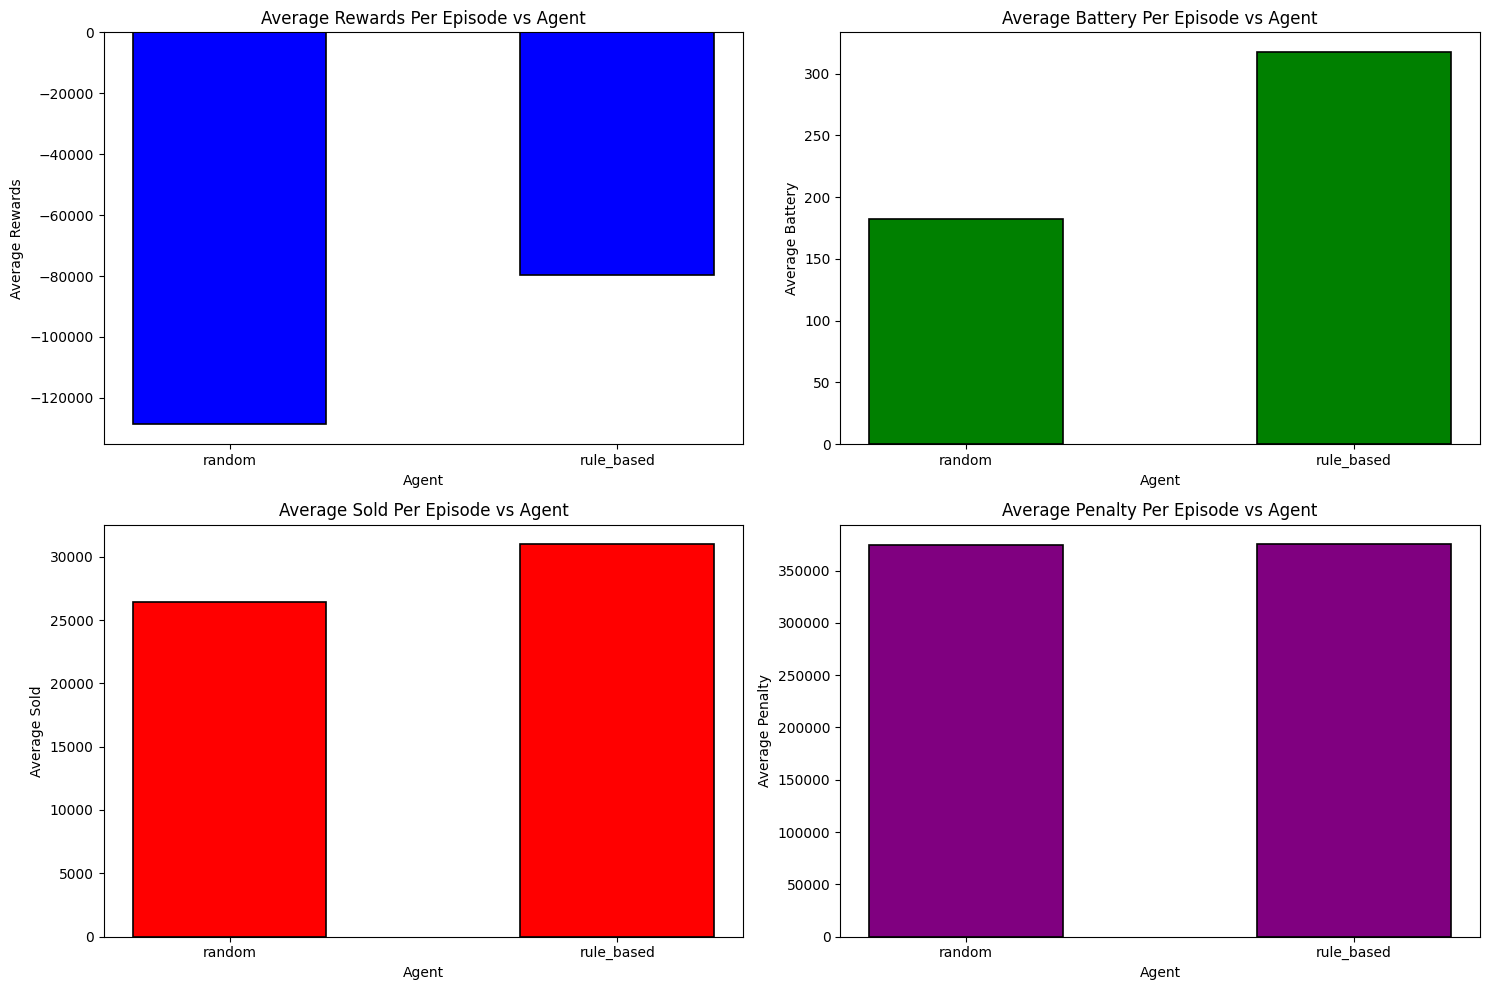

In [5]:
metrics = ['rewards', 'battery', 'sold', 'penalty']

colors = ['b', 'g', 'r', 'purple']  # Different colors for each metric

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid
values_agents_dict = {
    'random': {},
    'rule_based': {}
}
for ax, metric, color in zip(axes.flatten(), metrics, colors):
    values_agents = []
    for agent in agents.keys():
        values_agents.append(np.mean([sum(agents[agent][metric][i]) for i in range(NUM_EPISODES)]))
        values_agents_dict[agent][metric] = values_agents[-1]
    ax.bar(agents.keys(), values_agents, color=color,width=0.5,edgecolor='black',linewidth=1.2)
    
    ax.set_xlabel('Agent')
    ax.set_ylabel(f'Average {metric.capitalize()}')
    ax.set_title(f'Average {metric.capitalize()} Per Episode vs Agent')
    ax.grid(False)

plt.tight_layout()
plt.show()


## SAC

In [6]:
def SAC_rewards(model_path, num_episodes=NUM_EPISODES, num_steps=NUM_STEPS, deterministic=True, render=False, print_info=True):
    """
    Evaluates a trained SAC model on the custom environment for a fixed number of steps.
    Args:
        model_path (str): Path to the saved SAC model
        num_episodes (int): Number of episodes to evaluate the model
        num_steps (int): Number of steps to evaluate the model
        deterministic (bool): Whether to use deterministic or stochastic actions
        render (bool): Whether to render the environment
        print_info (bool): Whether to print the episode rewards
    Returns:
        list: List of total rewards for each episode
    """
    

    episodes = {
        'rewards': [],
        'battery_used_in_demand': [],
        'sold': [],
        'penalty': [] 
    }


    per_episode = {
        'rewards': [],
        'battery_used_in_demand': [],
        'sold': [],
        'penalty': [] 
    }
    model = SAC.load(model_path)
    for i in tqdm(range(num_episodes)):
        env = ElectricityMarketEnv(num_steps=num_steps)
        env = DummyVecEnv([lambda: env])
        obs = env.reset()
        for j in range(num_steps):
            action, _states = model.predict(obs, deterministic=deterministic)
            if print_info:
                print(f'{i}:{j}, soc {obs["soc"]}, demand {obs["demand"]}, price {obs["price"]}, renewable {obs["renewable"]}, action {action}')
            obs, reward, done,info = env.step(action)
            if print_info:
                print(f'reward {reward}')
            for key in episodes.keys():
                to_append = info[0][key]
                if isinstance(to_append, np.ndarray):
                    to_append = to_append[0]
                per_episode[key].append(to_append)
            
            if render:
                env.render()
            if done:
                break
        for key in episodes.keys():
            episodes[key].append(per_episode[key])
            per_episode[key] = []
        # print(f'rewards: {np.sum(rewards)}')
    return episodes['rewards'], episodes['battery_used_in_demand'], episodes['sold'], episodes['penalty']

def evaluate_SAC(SAC_MODEL_PATH):
    rewards_SAC,battery_SAC,sold_SAC,penalties_SAC = SAC_rewards(SAC_MODEL_PATH, num_episodes=NUM_EPISODES, num_steps=NUM_STEPS, deterministic=False, render=False,print_info=False)

    # SAC_episode_rewards = [sum(episode) for episode in rewards_SAC]
    # SAC_episode_battery = [np.mean(episode) for episode in battery_SAC]
    # SAC_episode_sold = [np.sum(episode) for episode in sold_SAC]
    # SAC_episode_penalties = [np.sum(episode) for episode in penalties_SAC]

    # print(f'Average reward: {np.mean(SAC_episode_rewards)}')
    # print(f'Average battery (%) used in demand: {np.mean(SAC_episode_battery)*100}')
    return rewards_SAC, battery_SAC, sold_SAC, penalties_SAC

In [7]:
if not os.path.exists('results'):
    os.makedirs('results')
save_path = f'results/sac_rewards_{NUM_EPISODES}.pkl'
steps = [1000,5000,8760,10000,20000,50000]

if not os.path.exists(save_path):
    steps_to_rewards = {}
    for step in steps:
        print(f'Running evaluation for SAC model trained for {step} steps')
        path = f'./models/sac_electricity_market_{step}'
        rewards, battery, sold, penalties = evaluate_SAC(path)
        steps_to_rewards[step] = {
            'rewards': rewards,
            'battery': battery,
            'sold': sold,
            'penalty': penalties
        }

        with open(save_path, 'wb') as f:
            pickle.dump(steps_to_rewards, f)
else:
    print('Already evaluated, loading results into steps_to_rewards')
    steps_to_rewards = pickle.load(open(save_path, 'rb'))

Running evaluation for SAC model trained for 1000 steps


  0%|          | 0/10 [00:00<?, ?it/s]         

Running evaluation for SAC model trained for 5000 steps


  0%|          | 0/10 [00:00<?, ?it/s]         

Running evaluation for SAC model trained for 8760 steps


  0%|          | 0/10 [00:00<?, ?it/s]         

Running evaluation for SAC model trained for 10000 steps


  0%|          | 0/10 [00:00<?, ?it/s]         

Running evaluation for SAC model trained for 20000 steps


  0%|          | 0/10 [00:00<?, ?it/s]         

Running evaluation for SAC model trained for 50000 steps


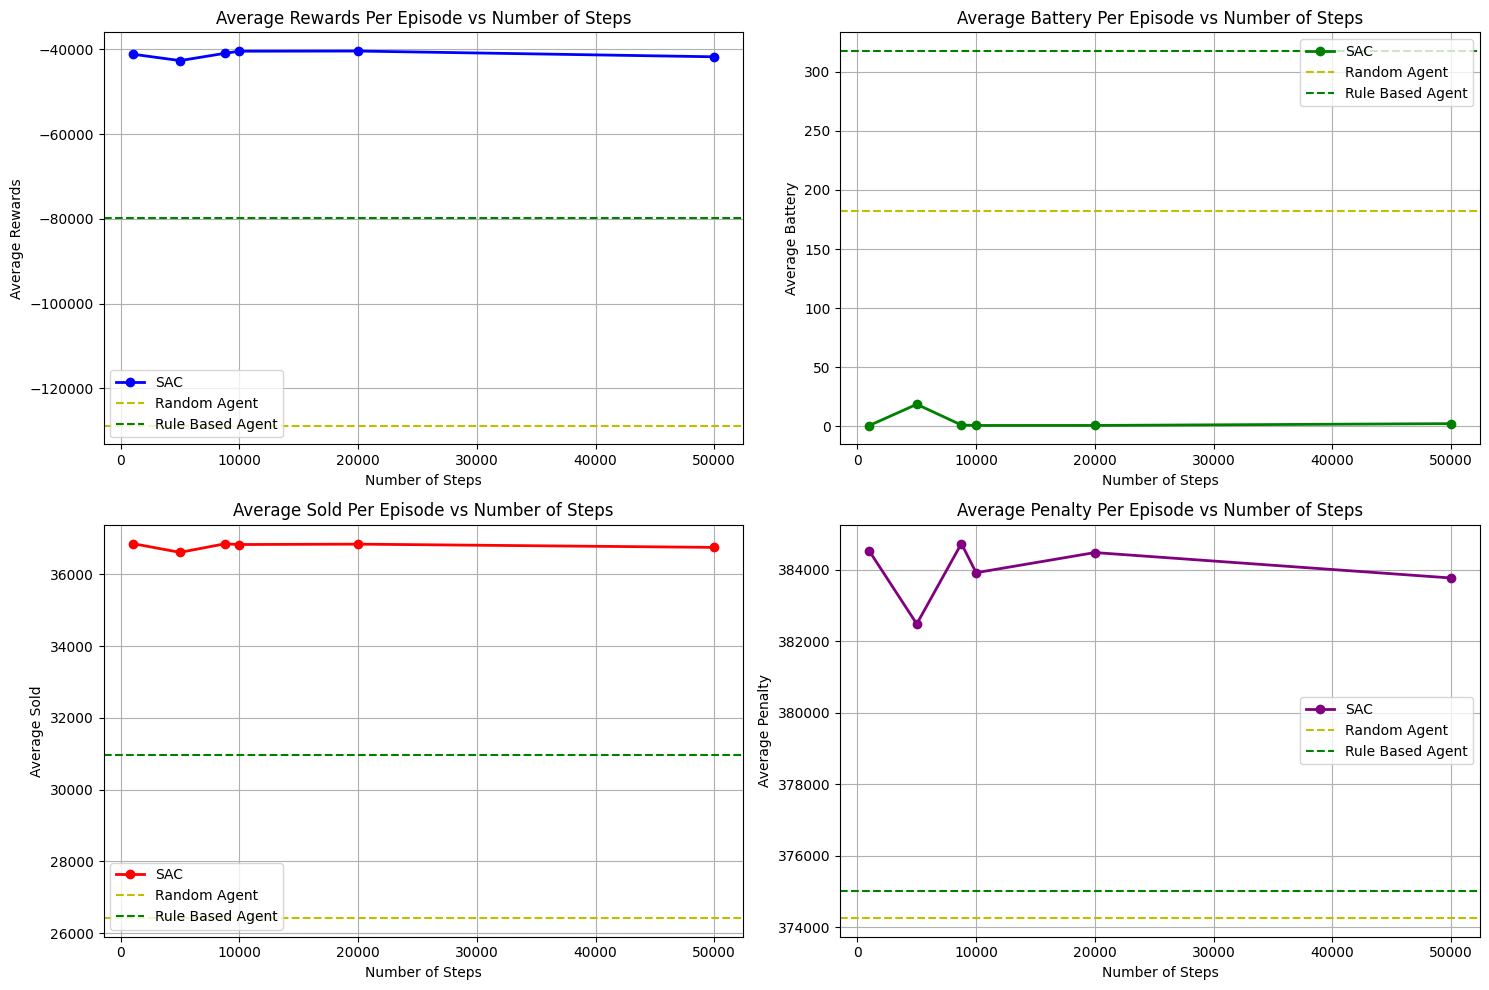

In [8]:
metrics = ['rewards', 'battery', 'sold', 'penalty']
colors = ['b', 'g', 'r', 'purple'] 

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  

for ax, metric, color in zip(axes.flatten(), metrics, colors):
    steps = list(steps_to_rewards.keys())
    values = [np.mean([sum(steps_to_rewards[step][metric][i]) for i in range(len(steps_to_rewards[1000]['rewards']))]) for step in steps]
    
    ax.plot(steps, values, marker='o', color=color, linestyle='-', linewidth=2, markersize=6, label='SAC')
    ax.set_xlabel('Number of Steps')
    ax.set_ylabel(f'Average {metric.capitalize()}')
    ax.set_title(f'Average {metric.capitalize()} Per Episode vs Number of Steps')
    ax.grid(True)
    ax.axhline(y=values_agents_dict['random'][metric], color='y', linestyle='--', label='Random Agent')
    ax.axhline(y=values_agents_dict['rule_based'][metric], color='g', linestyle='--', label='Rule Based Agent')
    ax.legend()
plt.tight_layout()
plt.show()


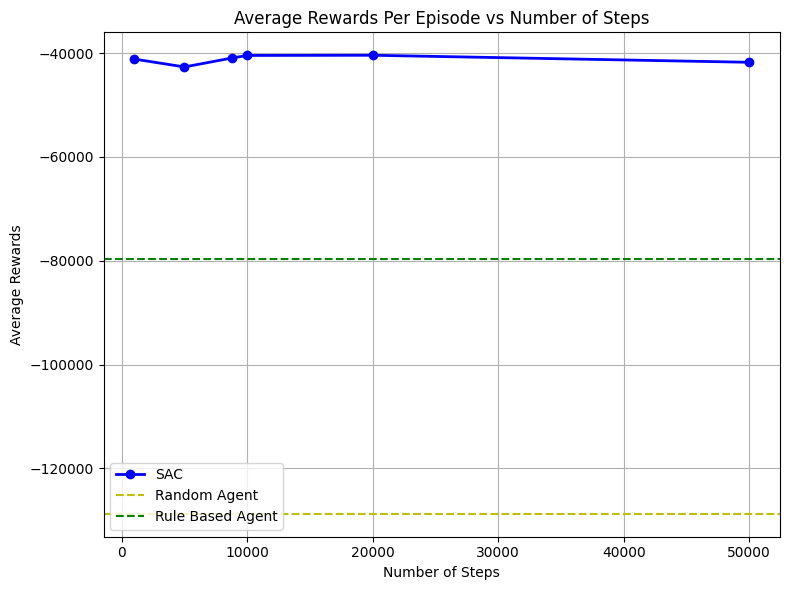

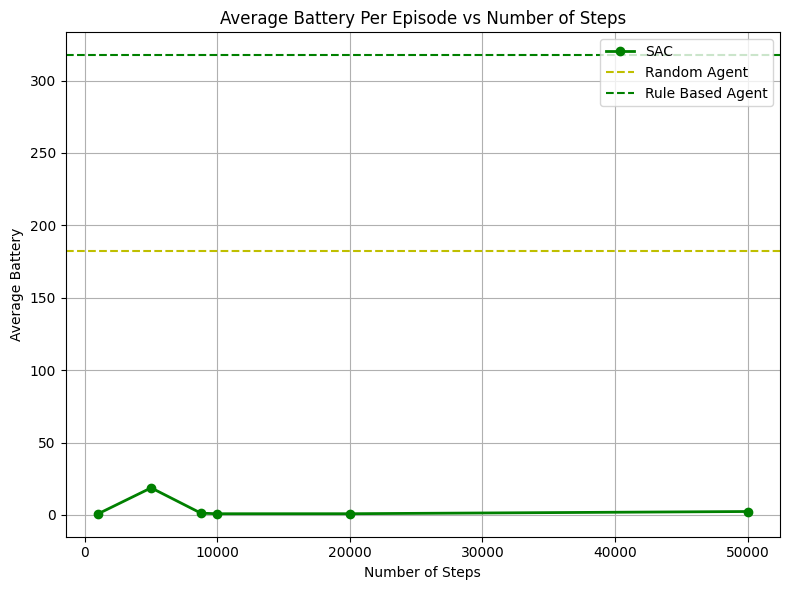

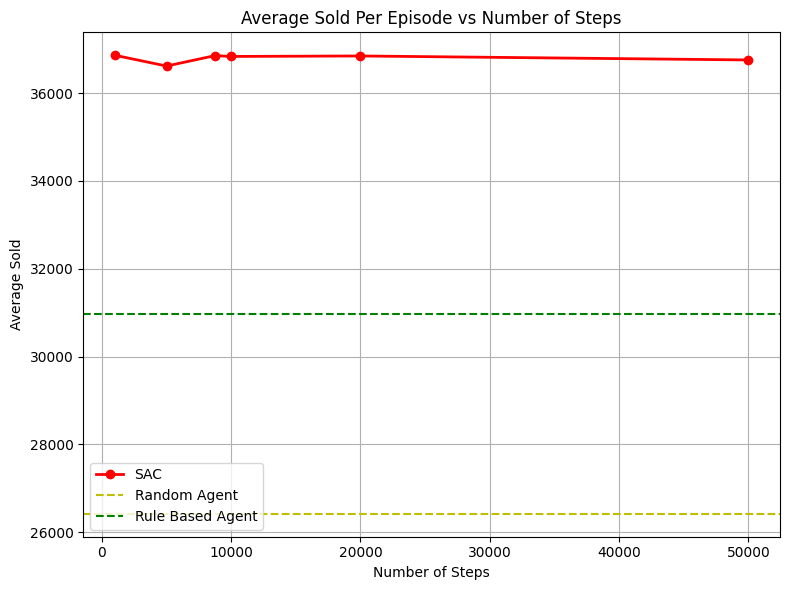

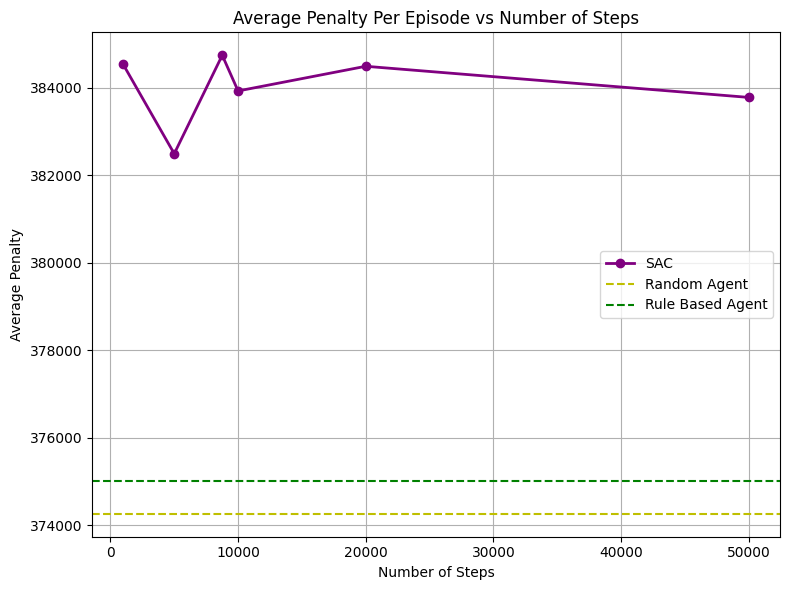

In [9]:
metrics = ['rewards', 'battery', 'sold', 'penalty']
colors = ['b', 'g', 'r', 'purple'] 

for metric, color in zip(metrics, colors):
    fig, ax = plt.subplots(figsize=(8, 6))  
    
    steps = list(steps_to_rewards.keys())
    values = [np.mean([sum(steps_to_rewards[step][metric][i]) for i in range(len(steps_to_rewards[1000]['rewards']))]) for step in steps]
    
    ax.plot(steps, values, marker='o', color=color, linestyle='-', linewidth=2, markersize=6, label='SAC')
    ax.set_xlabel('Number of Steps')
    ax.set_ylabel(f'Average {metric.capitalize()}')
    ax.set_title(f'Average {metric.capitalize()} Per Episode vs Number of Steps')
    ax.grid(True)
    ax.axhline(y=values_agents_dict['random'][metric], color='y', linestyle='--', label='Random Agent')
    ax.axhline(y=values_agents_dict['rule_based'][metric], color='g', linestyle='--', label='Rule Based Agent')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'./images/SAC_{metric}_vs_steps.png')
    plt.show()


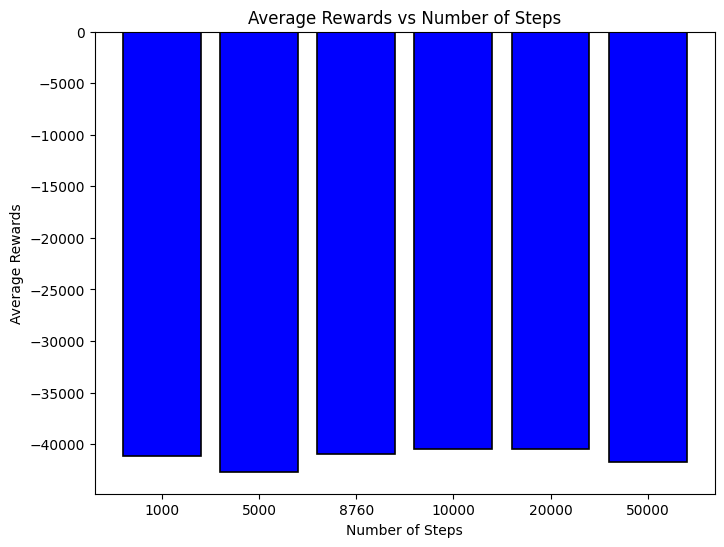

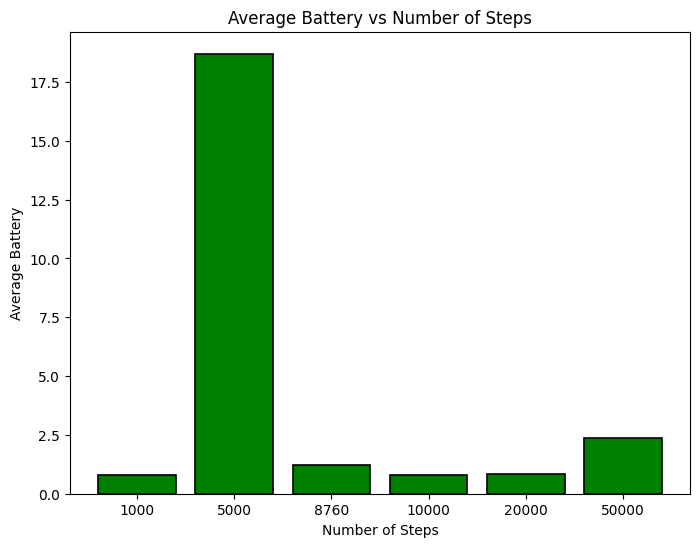

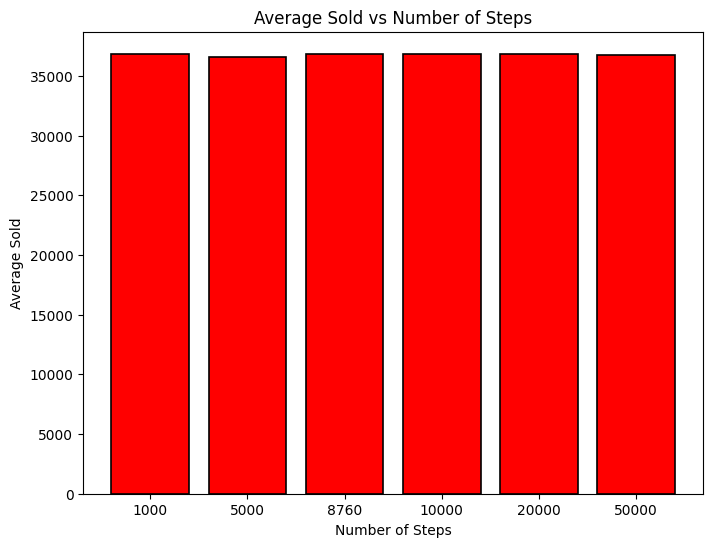

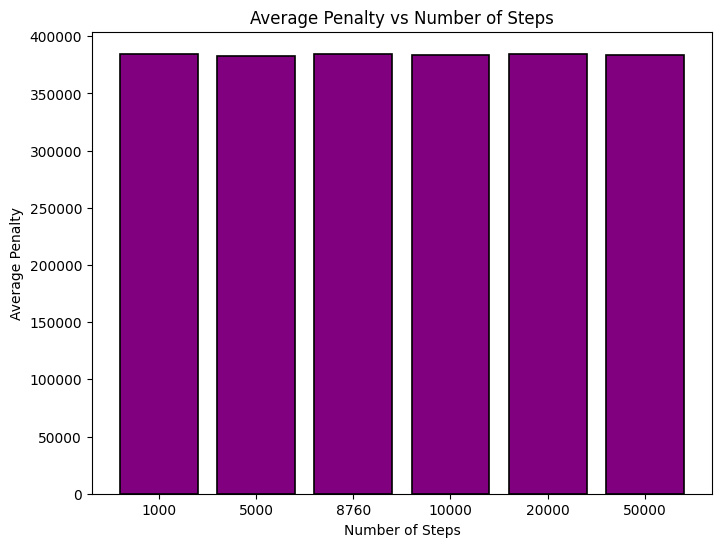

In [10]:
metrics = ['rewards', 'battery', 'sold', 'penalty']
colors = ['b', 'g', 'r', 'purple']   

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(8, 6))  
    
    steps = list(steps_to_rewards.keys())
    values = [np.mean([sum(steps_to_rewards[step][metric][i]) for i in range(len(steps_to_rewards[1000]['rewards']))]) for step in steps]


    x_positions = range(len(steps))  
    plt.bar(x_positions, values, color=color, edgecolor='black', linewidth=1.2)
    

    plt.xticks(x_positions, steps)  
    plt.xlabel('Number of Steps')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.title(f'Average {metric.capitalize()} vs Number of Steps')
    plt.grid(False)
    plt.savefig(f'./images/SAC_{metric}_vs_steps_bar.png')
    plt.show()  


## TAC

In [ ]:
from train_TAC import load_model,flatten_state,evaluate, TACAgent
import torch


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def init_agent(model_path="tac_agent_final.pth", state_dim=6, action_dim=1, history_length=10, device=None):
    """
    Initializes the TAC agent, loads the trained model, and returns the agent.
    
    Args:
        model_path (str): Path to the saved model file.
        state_dim (int): Dimension of the state space.
        action_dim (int): Dimension of the action space.
        history_length (int): Number of historical states to maintain.
        device (torch.device): Device to run the model on (CPU/GPU).
    
    Returns:
        TACAgent: The initialized and loaded TAC agent.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize the agent
    agent = TACAgent(state_dim, action_dim, history_length, device=device)

    # Load the trained model
    load_model(agent, filename=model_path)

    return agent 

In [ ]:
# TAC_MODEL_PATH = f'./Model_saves/tac_agent_final.pth'
# tac_agent = init_agent(model_path=TAC_MODEL_PATH, state_dim=6, action_dim=1, history_length=10, device=device)

tac_save_path = f'results/tac_rewards_{NUM_EPISODES}.pkl'
if not os.path.exists(tac_save_path):
    tac_steps = [1000,8760,10000]
    tac_steps_to_rewards = {}
    for tac_step in tac_steps:
        print(f'Running evaluation for TAC model trained for {tac_step} steps')
        TAC_MODEL_PATH = f'./models/steps_{tac_step}/tac_agent_final_{tac_step}.pth'
        tac_agent = init_agent(model_path=TAC_MODEL_PATH, state_dim=6, action_dim=1, history_length=10, device=device)
        tac_rewards, tac_battery, tac_sold, tac_penalties = evaluate(tac_agent, num_episodes=NUM_EPISODES, max_steps=NUM_STEPS)
        tac_steps_to_rewards[tac_step] = {
            'rewards': tac_rewards,
            'battery': tac_battery,
            'sold': tac_sold,
            'penalty': tac_penalties
        }
        with open(tac_save_path, 'wb') as f:
            pickle.dump(tac_steps_to_rewards, f)
else:
    print('Already evaluated, loading results to variable "tac_steps_to_rewards"')
    tac_steps_to_rewards = pickle.load(open(tac_save_path, 'rb'))

Already evaluated, loading results to variable "tac_steps_to_rewards"


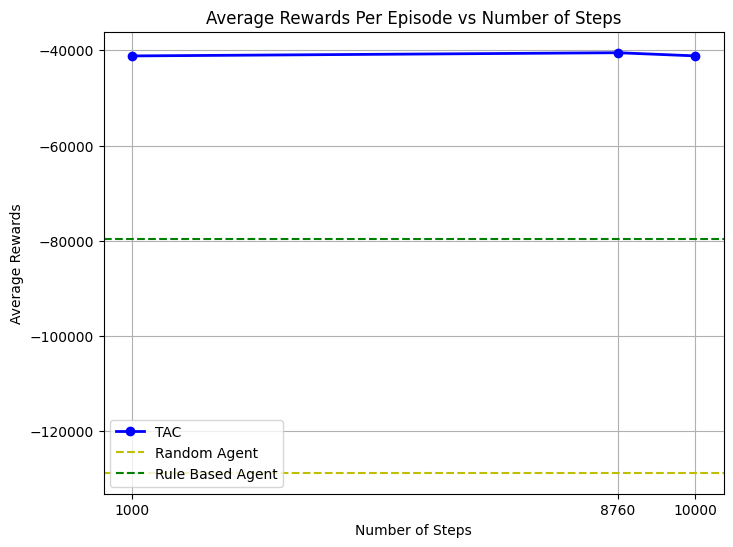

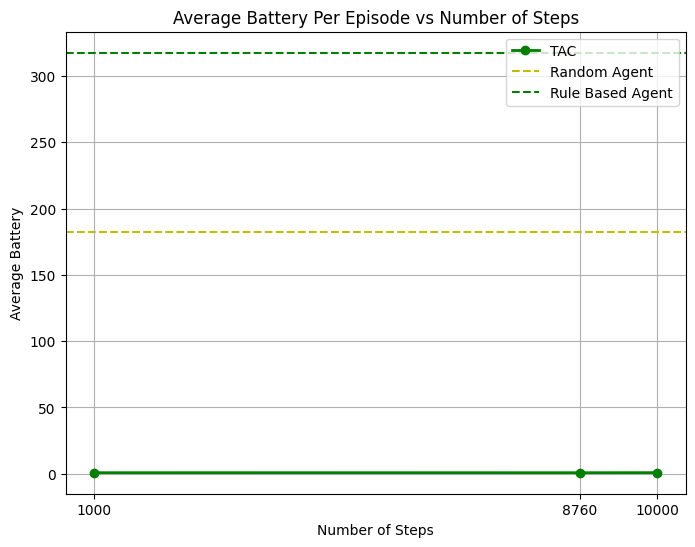

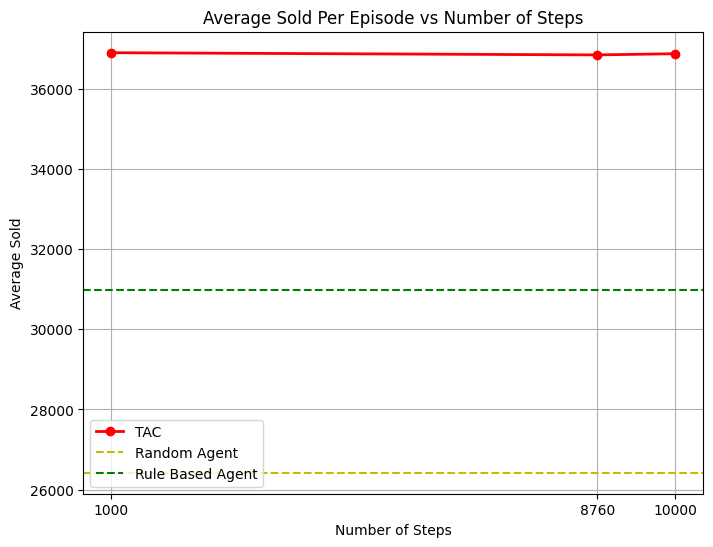

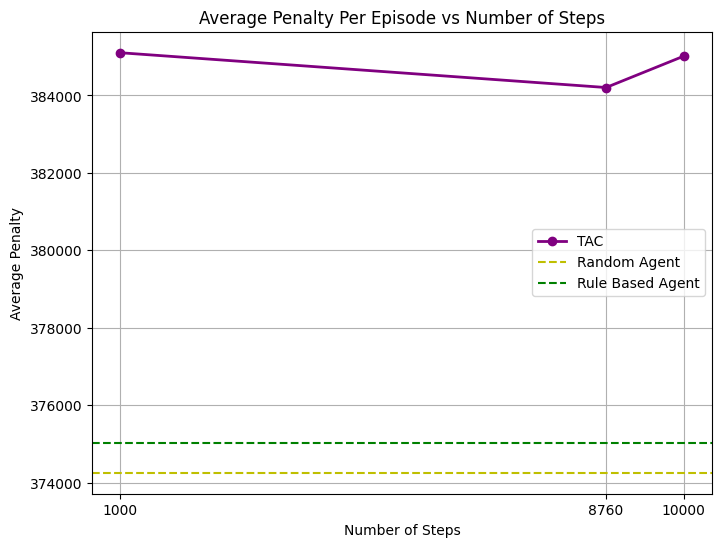

In [15]:
metrics = ['rewards', 'battery', 'sold', 'penalty']
colors = ['b', 'g', 'r', 'purple']   

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(8, 6)) 
    
    tac_steps = list(tac_steps_to_rewards.keys())
    values = [
        np.mean([
            sum(tac_steps_to_rewards[step][metric][i]) 
            for i in range(len(tac_steps_to_rewards[step][metric]))
        ]) 
        for step in tac_steps
    ]
    
    plt.plot(tac_steps, values, marker='o', color=color, linestyle='-', linewidth=2, markersize=6, label='TAC')

    plt.xlabel('Number of Steps')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.title(f'Average {metric.capitalize()} Per Episode vs Number of Steps')

    plt.axhline(y=values_agents_dict['random'][metric], color='y', linestyle='--', label='Random Agent')
    plt.axhline(y=values_agents_dict['rule_based'][metric], color='g', linestyle='--', label='Rule Based Agent')

    plt.legend()
    plt.grid(True)  
    plt.xticks(tac_steps)  
    plt.savefig(f'./images/TAC_{metric}_vs_steps.png')
    plt.show() 


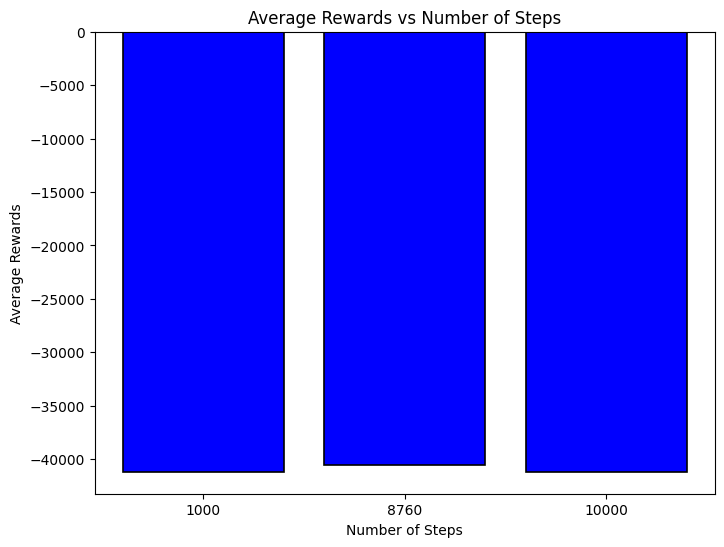

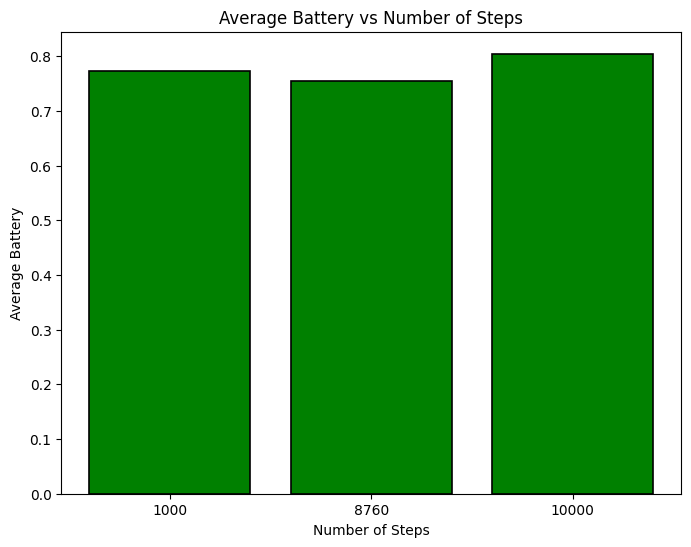

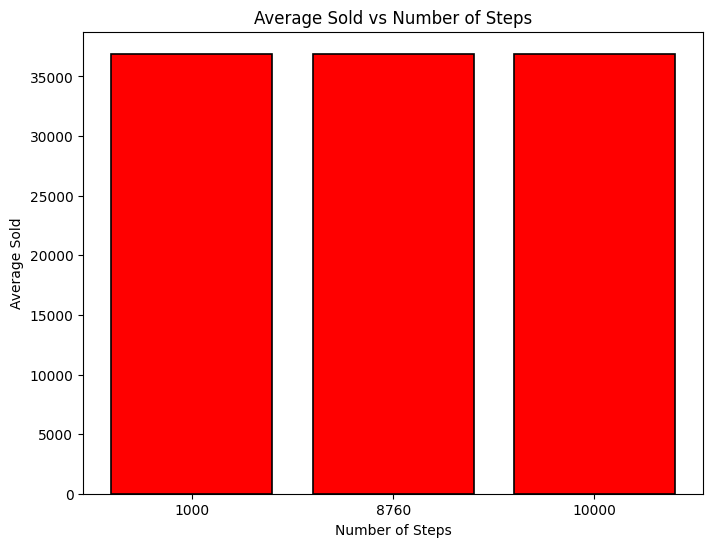

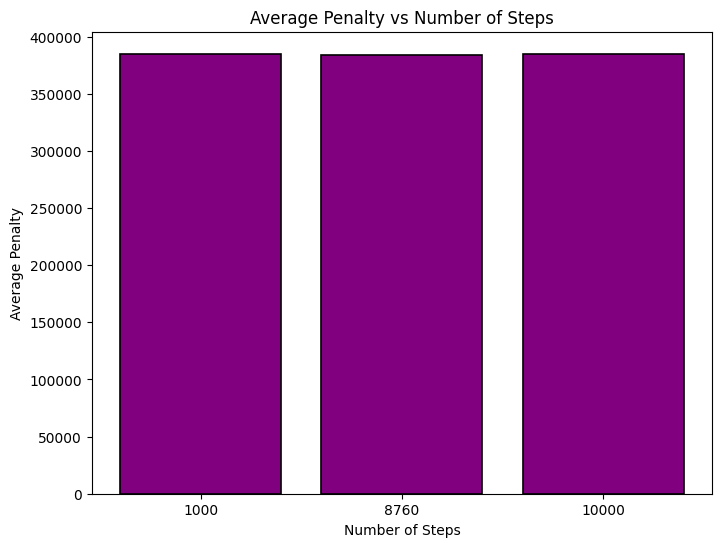

In [16]:
metrics = ['rewards', 'battery', 'sold', 'penalty']
colors = ['b', 'g', 'r', 'purple']  

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(8, 6)) 
    
    tac_steps = list(tac_steps_to_rewards.keys())
    values = [
        np.mean([
            sum(tac_steps_to_rewards[step][metric][i]) 
            for i in range(len(tac_steps_to_rewards[step][metric]))
        ]) 
        for step in tac_steps
    ]

    x_positions = range(len(tac_steps)) 
    plt.bar(x_positions, values, color=color, edgecolor='black', linewidth=1.2)
    
    plt.xticks(x_positions, tac_steps) 
    plt.xlabel('Number of Steps')
    plt.ylabel(f'Average {metric.capitalize()}')
    plt.title(f'Average {metric.capitalize()} vs Number of Steps')
    plt.grid(False)

    plt.show() 

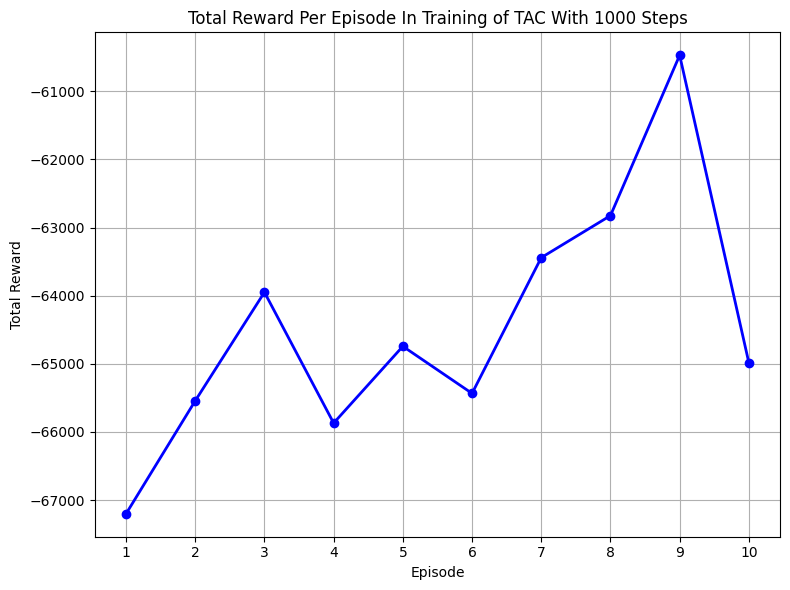

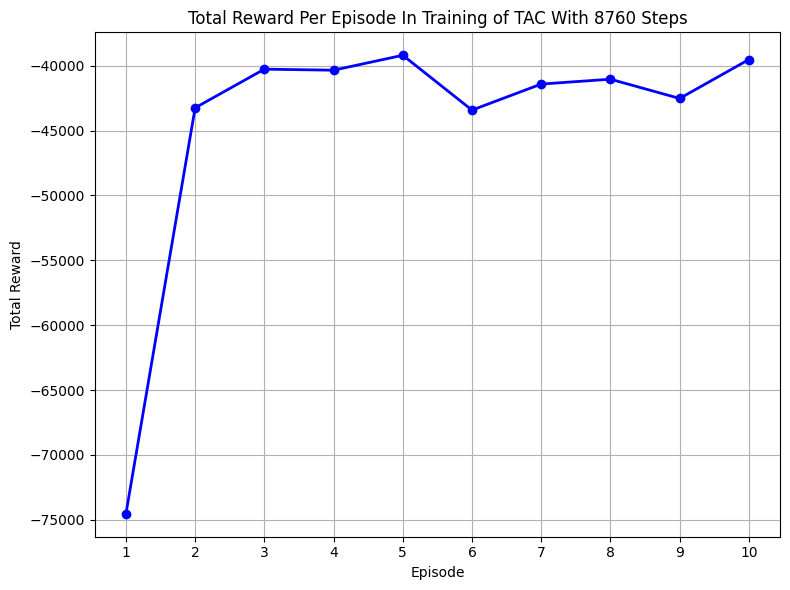

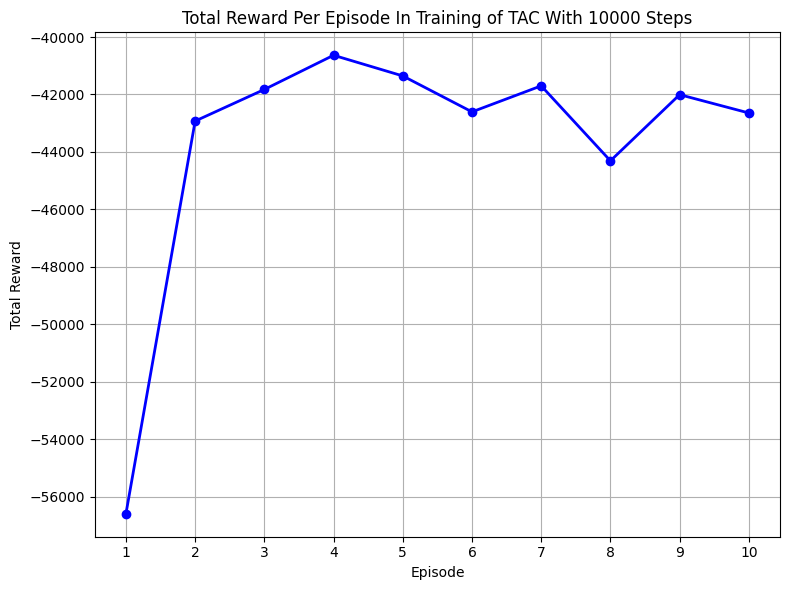

In [17]:
tac_steps = [1000,8760,10000]


for tac_step in tac_steps:
    with open(f'./models/steps_{tac_step}/reward_per_episode_{tac_step}.pkl', 'rb') as f:
        rewards_per_episode = pickle.load(f)
    fig, ax = plt.subplots(figsize=(8, 6))  
    values = list(rewards_per_episode.values())
    keys = [int(key)+1 for key in rewards_per_episode.keys()]
    ax.plot(keys, values, marker='o', color='b', linestyle='-', linewidth=2, markersize=6, label='TAC')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title(f'Total Reward Per Episode In Training of TAC With {tac_step} Steps')
    ax.grid(True)
    plt.tight_layout()
    plt.xticks(keys)
    plt.savefig(f'./images/TAC_reward_per_episode_{tac_step}.png')


## Plotting Demand,Price,Renewable

In [18]:
def plot_electricity_market_separate(env, days=30, time_resolution=200):
    """
    Plots electricity demand, price, and renewable generation in separate subplots.

    :param env: ElectricityMarketEnv instance.
    :param days: Number of days to simulate.
    :param time_resolution: Number of time points for smooth curves.
    """
    total_hours = days * 24  
    times = np.linspace(0, total_hours, time_resolution)

    demands = [env._compute_demand(t) for t in times]
    prices = [env._compute_price(t) for t in times]
    renewables = [env._compute_renewable(t) for t in times]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    #Demand
    axes[0].plot(times, demands, label="Demand (kWh)", color="blue", linewidth=2)
    axes[0].set_ylabel("Demand (kWh)")
    axes[0].set_title(f"Electricity Demand Over Time for {days} days")
    axes[0].legend()
    axes[0].grid(True)
    #Price
    axes[1].plot(times, prices, label="Price ($/kWh)", color="red", linewidth=2)
    axes[1].set_ylabel("Price ($/kWh)")
    axes[1].set_title(f"Electricity Price Over Time for {days} days")
    axes[1].legend()
    axes[1].grid(True)

    # Renewable
    axes[2].plot(times, renewables, label="Renewable Generation (kWh)", color="green", linewidth=2)
    axes[2].set_xlabel("Time (hours)")
    axes[2].set_ylabel("Renewable Generation (kWh)")
    axes[2].set_title(f"Renewable Energy Generation Over Time for {days} days")
    axes[2].legend()
    axes[2].grid(True)
    plt.savefig(f'./images/electricity_market_{days}_days.png')

    plt.tight_layout()
    plt.show()

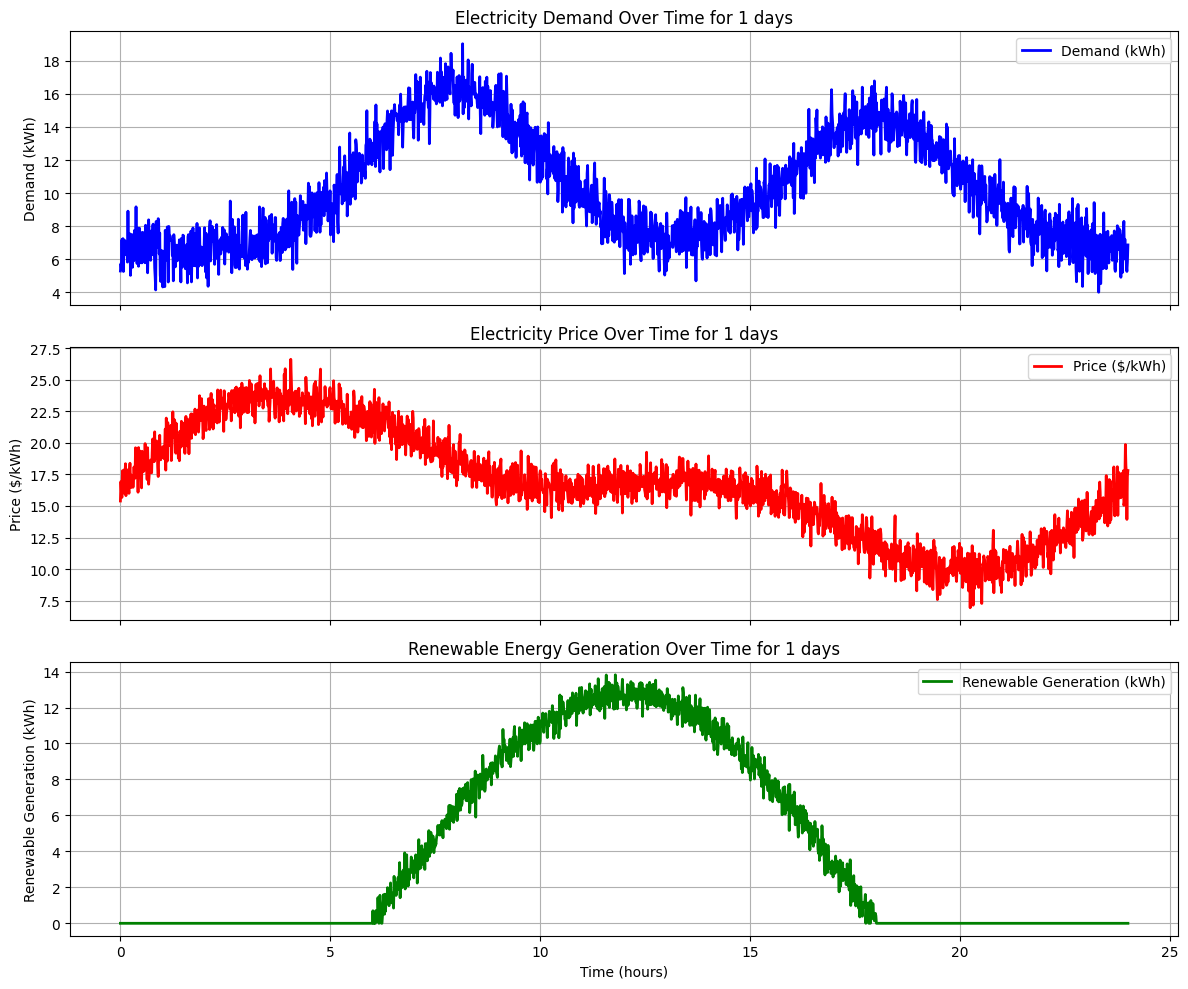

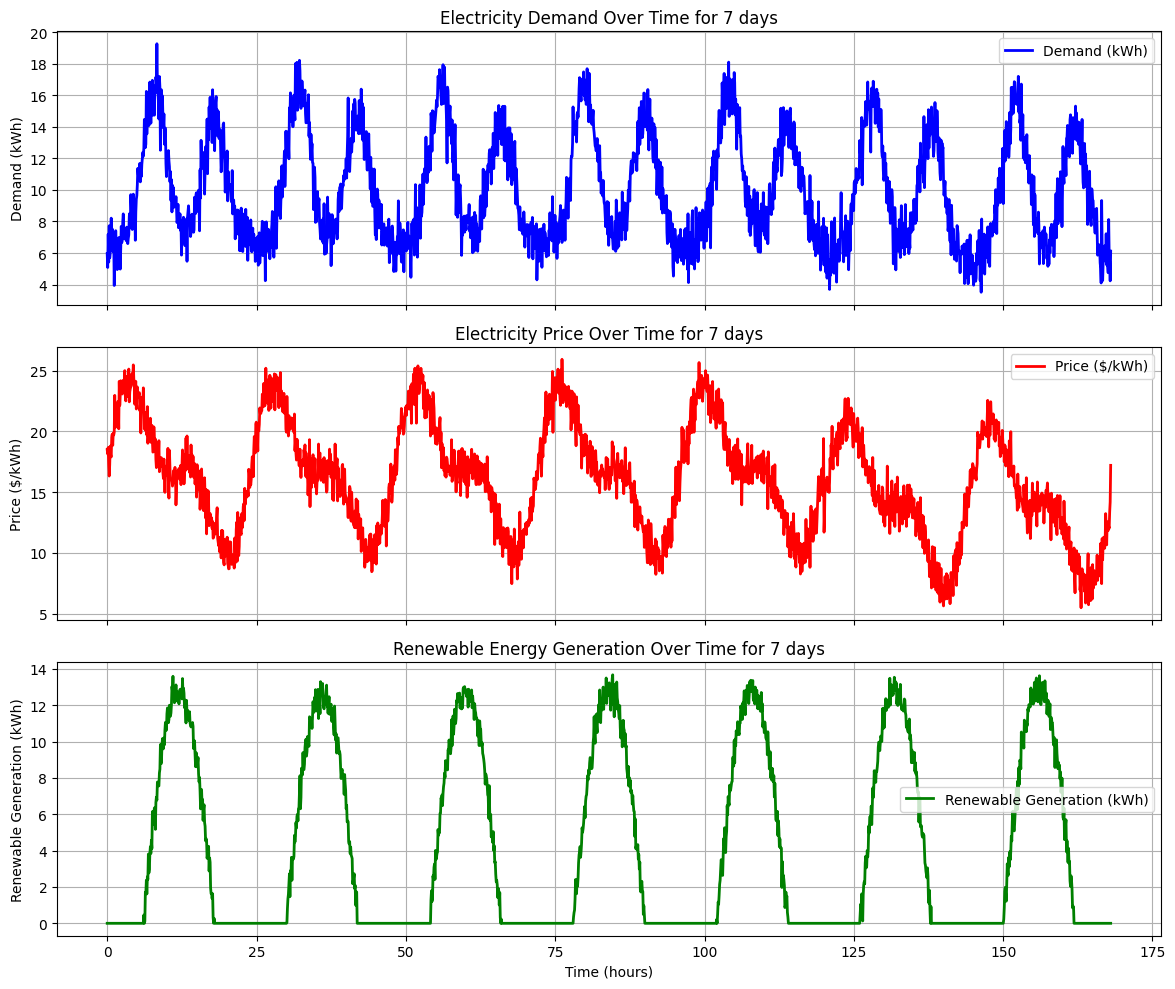

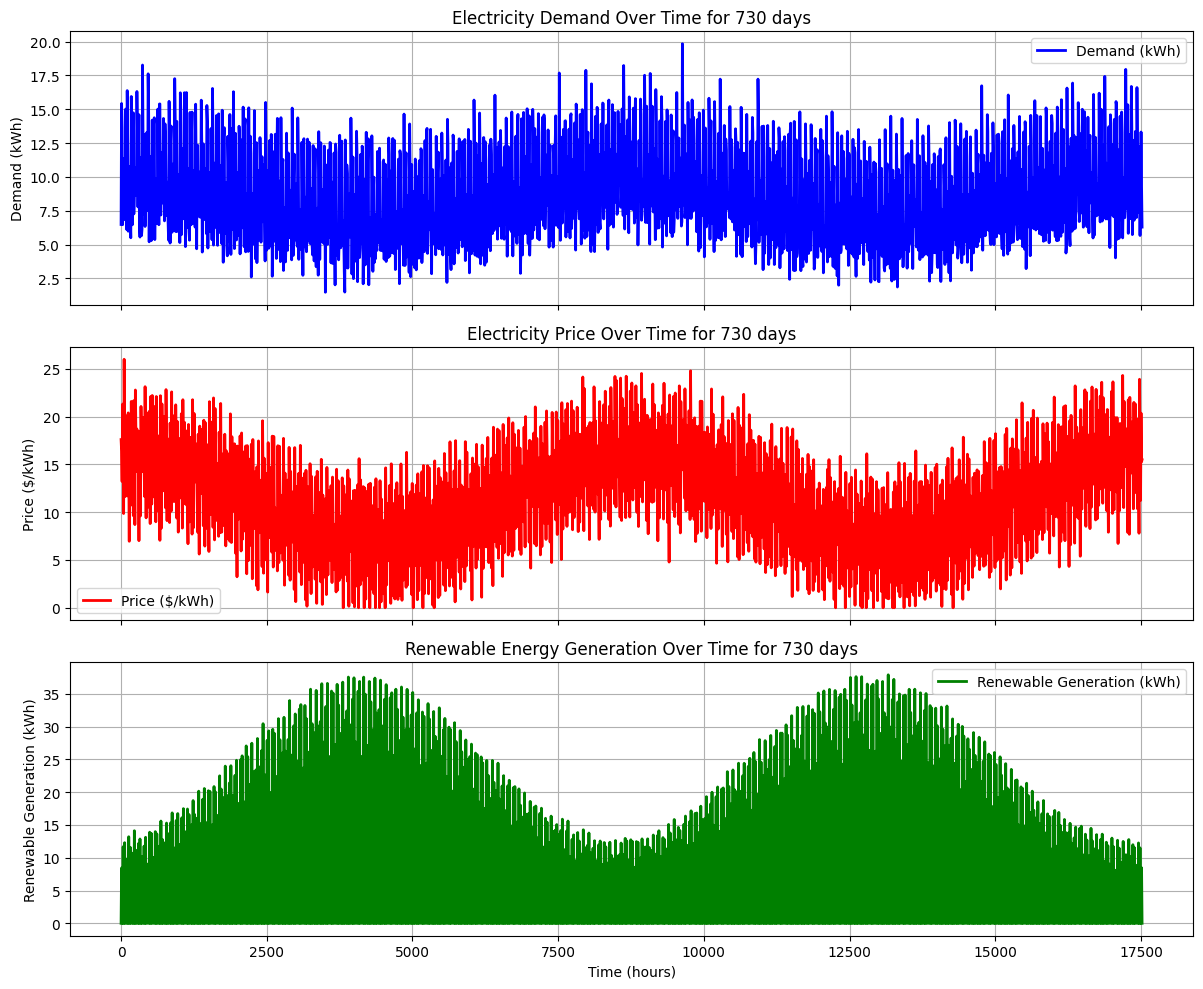

In [19]:
env = ElectricityMarketEnv()
for time in [1,7,365*2]:
    plot_electricity_market_separate(env, days=time, time_resolution=2000)
